In [64]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.signal import find_peaks
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Load data tables
Refer = pd.read_csv('C:/Users/Scott/Desktop/Projects/River_Data/RiverReferenceTable.csv')
Discharge = pd.read_csv('C:/Users/Scott/Desktop/Projects/River_Data/Historical/HistoricalDischarge.csv')
Precip = pd.read_csv('C:/Users/Scott/Desktop/Projects/River_Data/Historical/HistoricalPrecip.csv')

# Standardize Date and River Names to be joined
Discharge['Date'] = pd.to_datetime(Discharge.DateTime).dt.date
Discharge = Discharge.set_index('Name').join(Refer.set_index('USGS Name')).reset_index()[[
    'Date','Value','VariableDescription','Name','RiverName','FishType']]

Precip = Precip.set_index('Name').join(Refer.set_index('Name')).reset_index()[[
    'Date','Precip','Name','RiverName','FishType']]

# Create Avg Daily Discharge
Avg_Discharge = Discharge.groupby(['Date','Name','RiverName','FishType']).mean().reset_index()

# Remove incorrect data
Avg_Discharge = Avg_Discharge.loc[Avg_Discharge.Value>0]

Avg_Discharge.head()

,Date,Name,RiverName,FishType,Value
0,2020-10-19,East Fork Carson,East Fork,Trout,31.896875
1,2020-10-19,East Walker,East Walker,Trout,51.300000
2,2020-10-19,Eel River Fort Seward,Eel,Steelhead,33.240625
3,2020-10-19,Eel River Scotia,Eel,Steelhead,65.256250
4,2020-10-19,Hat Creek,Hat Creek,Trout,122.437500


#### Eel River Daily Avg Discharge
Review the data quality and ensure the information looks correct

In [65]:
# Reduce data to Eel River only
eel = Avg_Discharge.loc[Avg_Discharge['Name']=='Eel River Scotia']
eel.reset_index(inplace=True)
eel = eel.drop(columns='index')

# Create column for slope of discharge
eel['CFS_Slope'] = eel.Value.diff()

# Retrieve values of Slope
SlopeValues = eel.CFS_Slope.values

# Define the threshold for what is a good day for fishing
#       - slope between day CFS values must be at least 1 STD from the mean 
border = eel.CFS_Slope.mean()+(eel.CFS_Slope.std()/2)

# Define troughs that are below the threshold
peaks, _ = find_peaks(-SlopeValues, height=border)

# Logic to build the best day flag
#       - if the value is a trough point or has a negative low and is above 1 STD from the mean then also consider a good day 
bestdays = []
for i in range(len(eel.Value)):
    if i in peaks:
        x = 1
    elif (eel.CFS_Slope[i]<0) & (eel.Value[i]>=border):
        x = 1
    else: x = 0
    bestdays.append(x)
eel['BestDays'] = bestdays

eel.head()

,Date,Name,RiverName,FishType,Value,CFS_Slope,BestDays
0,2020-10-19,Eel River Scotia,Eel,Steelhead,65.256250,NaN,0
1,2020-10-20,Eel River Scotia,Eel,Steelhead,65.536458,0.280208,0
2,2020-10-21,Eel River Scotia,Eel,Steelhead,64.127083,-1.409375,0
3,2020-10-22,Eel River Scotia,Eel,Steelhead,64.877083,0.750000,0
4,2020-10-23,Eel River Scotia,Eel,Steelhead,73.515625,8.638542,0


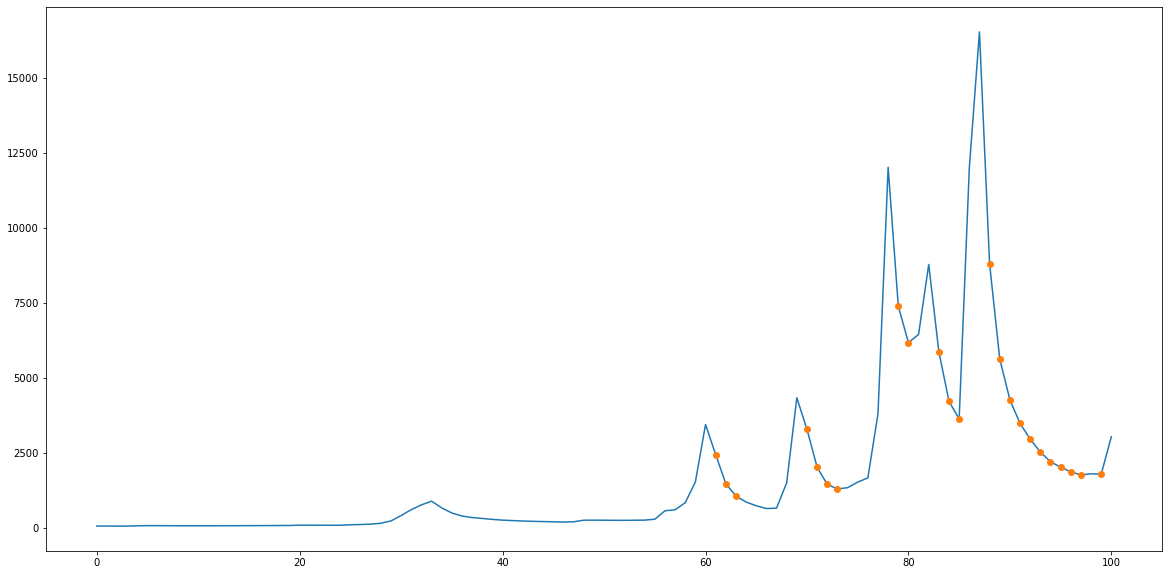

In [66]:
# dates = eel.loc[eel.BestDays==1].Date.values
# BestDayValues = eel.Value.loc[eel.BestDays==1].values

# fig = px.line(eel, x="Date", y="Value", title='Eel River (Scotia) - Daily CFS')
# fig.add_scatter(x=dates,y=BestDayValues,mode='markers',name='Good fishing days')
# fig.show()

plt.figure(figsize=(20,10))
eel.Value.plot()
plt.plot(eel.Value.loc[eel.BestDays==1],'o')

In [67]:
# Replicate for all rivers
Rivers = []
for river in Avg_Discharge.Name.unique():
    df = Avg_Discharge.loc[Avg_Discharge.Name == river]
    df.reset_index(inplace=True)
    df = df.drop(columns='index')

    # Create column for slope of discharge
    df['CFS_Slope'] = df.Value.diff()

    # Retrieve values of Slope
    SlopeValues = df.CFS_Slope.values

    # Define the threshold for what is a good day for fishing
    #       - slope between day CFS values must be at least 1 STD from the mean 
    border = df.CFS_Slope.mean()+(df.CFS_Slope.std()/2)

    # Define troughs that are below the threshold
    peaks, _ = find_peaks(-SlopeValues, height=border)

    # Logic to build the best day flag
    #       - if the value is a trough point or has a negative low and is above 1 STD from the mean then also consider a good day 
    bestdays = []
    for i in range(len(df.Value)):
        if i in peaks:
            x = 1
        elif (df.CFS_Slope[i]<0) & (df.Value[i]>=border):
            x = 1
        else: x = 0
        bestdays.append(x)
    df['BestDays'] = bestdays
    Rivers.append(df)
Rivers_Flow = pd.concat(Rivers)

In [68]:
Precip['Date'] = pd.to_datetime(Precip.Date).dt.date
Precip['Date_Name'] = Precip.Date.astype('str')+'_'+Precip.Name
Precip = Precip[['Date_Name','Date','Name','Precip']].groupby(['Date','Name','Date_Name']).mean().reset_index()

Rivers_Flow['Date_Name'] = Rivers_Flow.Date.astype('str')+'_'+Rivers_Flow.Name
Rivers_Flow['CFS'] = Rivers_Flow['Value']
Rivers_Flow.drop(columns=['Value'],inplace=True)

Rivers_Flow_Rain = Rivers_Flow.set_index('Date_Name').join(Precip[['Date_Name','Precip']].set_index('Date_Name'))
Rivers_Flow_Rain['Precip'] = Rivers_Flow_Rain.Precip.fillna(0)
RiverList = Rivers_Flow_Rain.Name.unique()
full = Rivers_Flow_Rain.loc[Rivers_Flow_Rain.Precip.isnull()==False]

# Lag Precip data by correlation strength to river flow
RiverData = pd.DataFrame()
for n in RiverList:
    s = 0
    CorrList = list()
    while s < 10:
        d = full[['CFS','Precip']].loc[full.Name==n]
        d['Precip'] = d['Precip'].shift(s)
        r = d.dropna()
        corr = r.Precip.corr(r.CFS)
        points = len(r.CFS)
        CorrList.append([s,corr,points])
        s+=1
    Corrs = pd.DataFrame(CorrList,columns=['PrecipLag','Corr','NumPoints'])
    BestShift = Corrs.sort_values(by='Corr',ascending=False).head(1)
    BestShift['Name'] = n
    RiverData = RiverData.append(BestShift)

In [69]:
full.head()

,Date,Name,RiverName,FishType,CFS_Slope,BestDays,CFS,Precip
Date_Name,,,,,,,,
2020-10-19_East Fork Carson,2020-10-19,East Fork Carson,East Fork,Trout,NaN,0,31.896875,0.000000
2020-10-20_East Fork Carson,2020-10-20,East Fork Carson,East Fork,Trout,0.297222,0,32.194097,0.000000
2020-10-21_East Fork Carson,2020-10-21,East Fork Carson,East Fork,Trout,0.683681,0,32.877778,0.000000
2020-10-22_East Fork Carson,2020-10-22,East Fork Carson,East Fork,Trout,0.357516,0,33.235294,0.714286
2020-10-23_East Fork Carson,2020-10-23,East Fork Carson,East Fork,Trout,1.090053,0,34.325347,0.000000


In [70]:
RiverData.loc[(RiverData.NumPoints>=30)&(RiverData.Corr>=.5)].sort_values('Corr',ascending=False )

,PrecipLag,Corr,NumPoints,Name


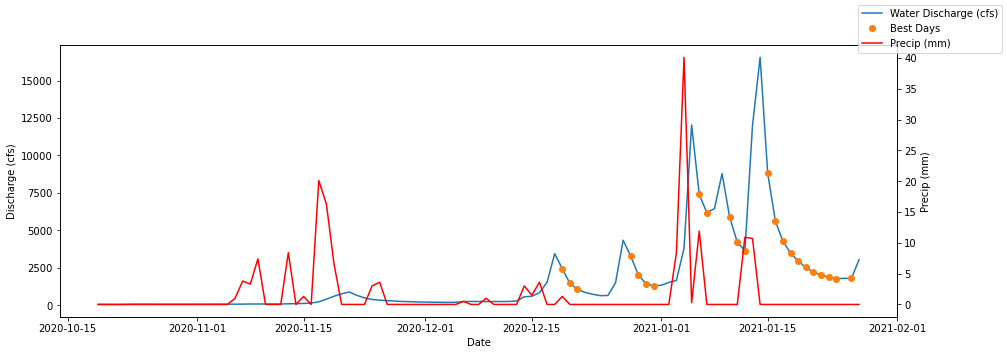

In [121]:
# eel = full.loc[full['Name']=='Eel River Scotia']
# eel.reset_index(inplace=True)
# eel['Precip_Shift'] = eel.Precip.shift(1)
# dates = eel.loc[eel.BestDays==1].Date.values
# BestDayValues = eel.CFS.loc[eel.BestDays==1].values
# # Create figure with secondary y-axis
# fig = make_subplots(specs=[[{"secondary_y": True}]])

# # Add traces
# fig.add_trace(
#     go.Scatter(x=eel.Date, y=eel.CFS, name="CFS"),
#     secondary_y=False,
# )

# fig.add_trace(
#     go.Scatter(x=eel.Date, y=eel.Precip, name="Precip"),
#     secondary_y=True,
# )

# # Add figure title
# fig.update_layout(
#     title_text="Precip & Discharge Timeline"
# )

# # Set x-axis title
# fig.update_xaxes(title_text="Date")

# # Set y-axes titles
# fig.update_yaxes(title_text="Discharge (cfs)", secondary_y=False)
# fig.update_yaxes(title_text="Precip (mm)", secondary_y=True)
# fig.add_scatter(x=dates,y=BestDayValues,mode='markers',name='Good fishing days')
# fig.show()

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(eel.Date,eel.CFS,label='Water Discharge (cfs)')
ax.plot(eel.Date.loc[eel.BestDays==1],eel.CFS.loc[eel.BestDays==1],'o',label='Best Days')
ax2 = ax.twinx()
ax2.plot(eel.Date,eel.Precip,'r',label='Precip (mm)')
ax.set_xlabel('Date')
ax.set_ylabel('Discharge (cfs)')
ax2.set_ylabel('Precip (mm)')
fig.legend()

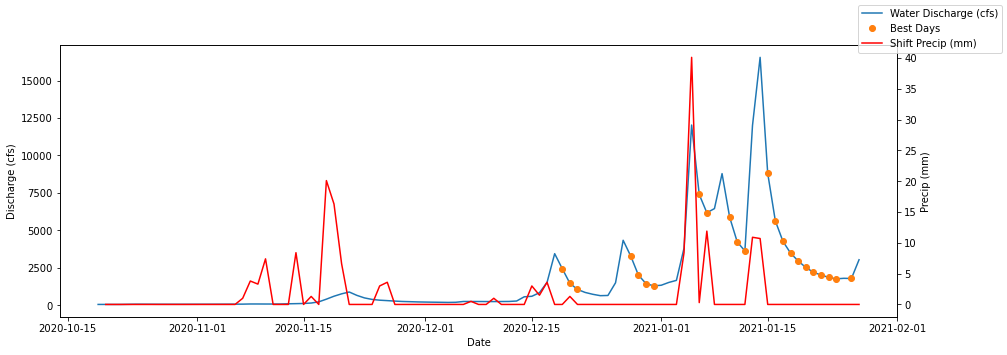

In [122]:
# # Create figure with secondary y-axis
# fig = make_subplots(specs=[[{"secondary_y": True}]])

# # Add traces
# fig.add_trace(
#     go.Scatter(x=eel.Date, y=eel.CFS, name="CFS"),
#     secondary_y=False,
# )

# fig.add_trace(
#     go.Scatter(x=eel.Date, y=eel.Precip_Shift, name="Precip"),
#     secondary_y=True,
# )

# # Add figure title
# fig.update_layout(
#     title_text="Shift Precip to align with Discharge"
# )

# # Set x-axis title
# fig.update_xaxes(title_text="Date")

# # Set y-axes titles
# fig.update_yaxes(title_text="Discharge (cfs)", secondary_y=False)
# fig.update_yaxes(title_text="Precip (mm)", secondary_y=True)
# fig.add_scatter(x=dates,y=BestDayValues,mode='markers',name='Good fishing days')
# fig.show()


fig, ax = plt.subplots(figsize=(15,5))
ax.plot(eel.Date,eel.CFS,label='Water Discharge (cfs)')
ax.plot(eel.Date.loc[eel.BestDays==1],eel.CFS.loc[eel.BestDays==1],'o',label='Best Days')
ax2 = ax.twinx()
ax2.plot(eel.Date,eel.Precip_Shift,'r',label='Shift Precip (mm)')
ax.set_xlabel('Date')
ax.set_ylabel('Discharge (cfs)')
ax2.set_ylabel('Precip (mm)')
fig.legend()

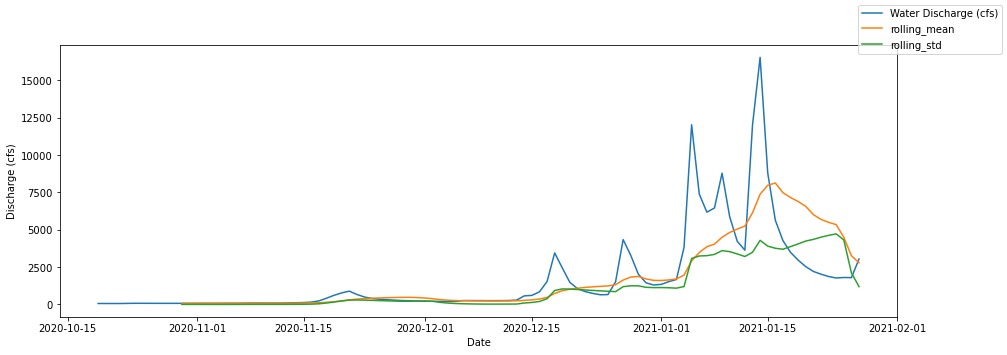

In [125]:


rolling_mean = eel.CFS.rolling(window = 12).mean()
rolling_std = eel.CFS.rolling(window = 12).std()

# # Create figure with secondary y-axis
# fig = make_subplots(specs=[[{"secondary_y": False}]])

# # Add traces
# fig.add_trace(
#     go.Scatter(x=eel.Date, y=eel.CFS, name="CFS"),
#     secondary_y=False,
# )

# fig.add_trace(
#     go.Scatter(x=eel.Date, y=rolling_mean, name="rolling_mean"),
#     secondary_y=False,
# )

# fig.add_trace(
#     go.Scatter(x=eel.Date, y=rolling_std, name="rolling_std"),
#     secondary_y=False,
# )
# # Add figure title
# fig.update_layout(
#     title_text="Rolling Mean & Rolling Standard Deviation - Review regressions of the water flow for stationarity signals."
# )

# # Set x-axis title
# fig.update_xaxes(title_text="Date")

# # Set y-axes titles
# fig.update_yaxes(title_text="Discharge (cfs)", secondary_y=False)
# fig.show()

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(eel.Date,eel.CFS,label='Water Discharge (cfs)')
ax.plot(eel.Date,rolling_mean,label='rolling_mean')
ax.plot(eel.Date,rolling_std,label='rolling_std')
ax.set_xlabel('Date')
ax.set_ylabel('Discharge (cfs)')
fig.legend()

In [ ]:
# P-Value is over 5% which does not reject the null hypothesis 
adf_test = adfuller(eel.CFS)
adf_test[1]

0.2781218641104468

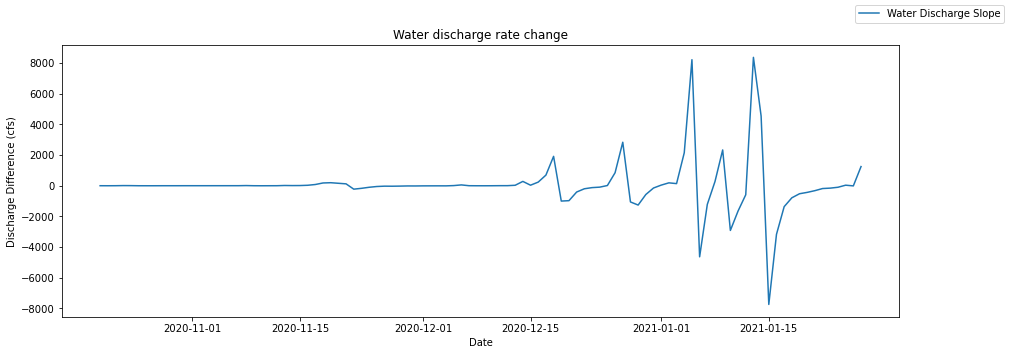

In [130]:
eel.CFS_Slope

# fig = px.line(x=eel.Date,y=eel.CFS_Stationary)
# fig.update_layout(
#     title_text="Derive slope from water flow"
# )
# fig.show()

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(eel.Date,eel.CFS_Slope,label='Water Discharge Slope')
ax.set_xlabel('Date')
ax.set_ylabel('Discharge Difference (cfs)')
ax.set_title('Water discharge rate change')
fig.legend()

In [132]:
# P-Value is under 5% which rejects the null hypothesis 
adf_test = adfuller(eel.CFS_Slope.dropna())
adf_test[1]

0.02561775965410392

In [ ]:
# Split Data into train and test
split = '2021-01-15'
eel['Date'] = pd.to_datetime(eel.Date,format='%Y-%m-%d')
eel_test = eel.loc[eel.Date>=split]
eel_train = eel.loc[eel.Date<split]

<ipython-input-38-b0df924b44f7>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



c:\Users\Scott\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



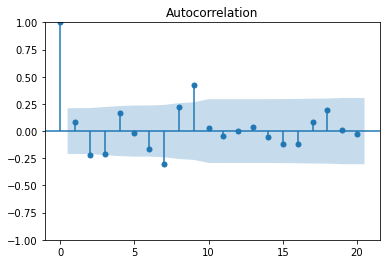

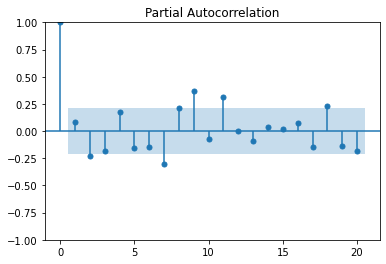

In [ ]:
acf_diff = plot_acf(eel_train.CFS_Slope.dropna())
pacf_diff = plot_pacf(eel_train.CFS_Slope.dropna())

In [ ]:
model = ARIMA(eel_train.CFS, order=(2,1,5))
model_fit = model.fit()
model_fit.summary()

c:\Users\Scott\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\Scott\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CFS   No. Observations:                   88
Model:                 ARIMA(2, 1, 5)   Log Likelihood                -748.689
Date:                Sun, 19 Feb 2023   AIC                           1513.378
Time:                        12:44:54   BIC                           1533.106
Sample:                             0   HQIC                          1521.322
                                 - 88                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3146      0.234      1.344      0.179      -0.144       0.773
ar.L2         -0.2932      0.364     -0.805      0.421      -1.007       0.421
ma.L1         -0.3465      0.189     -1.836      0.066      -0.716       0.023
ma.L2         -0.0043      0.509     -0.008      0.993      -1.002       0.993
ma.L3          0.3156      0.105      3.014      0.003       0.110       0.521
ma.L4          0.3711      0.167      2.226      0.026       0.044       0.698
ma.L5         -0.6741      0.238     -2.833      0.005      -1.140      -0.208
sigma2      2.015e+06    1.9e-07   1.06e+13      0.000    2.01e+06    2.01e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):               733.80
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):           18257.17   Skew:                             2.47
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.95e+30. Standard errors may be unstable.
"""

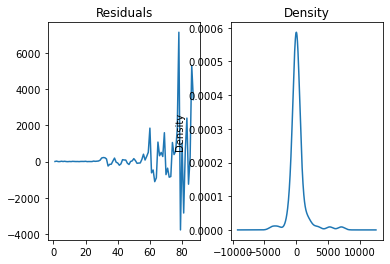

In [ ]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals',ax=ax[0])
residuals.plot(title='Density',kind='kde',ax=ax[1])
plt.show()


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

eel_train['CFS_Rolling'] = eel_train.CFS.rolling(window=3,min_periods=1).mean()
eel_train['CFS_Slope_Rolling'] = eel_train.CFS.rolling(window=3,min_periods=1).mean()

eel_train


<ipython-input-42-56184f53366b>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-42-56184f53366b>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Date_Name,Date,Name,RiverName,FishType,CFS_Slope,BestDays,CFS,Precip,Precip_Shift,CFS_Rolling,CFS_Slope_Rolling
0,2020-10-19_Eel River Scotia,2020-10-19,Eel River Scotia,Eel,Steelhead,NaN,0,65.256250,0.0,NaN,65.256250,65.256250
1,2020-10-20_Eel River Scotia,2020-10-20,Eel River Scotia,Eel,Steelhead,0.280208,0,65.536458,0.0,0.0,65.396354,65.396354
2,2020-10-21_Eel River Scotia,2020-10-21,Eel River Scotia,Eel,Steelhead,-1.409375,0,64.127083,0.0,0.0,64.973264,64.973264
3,2020-10-22_Eel River Scotia,2020-10-22,Eel River Scotia,Eel,Steelhead,0.750000,0,64.877083,0.0,0.0,64.846875,64.846875
4,2020-10-23_Eel River Scotia,2020-10-23,Eel River Scotia,Eel,Steelhead,8.638542,0,73.515625,0.0,0.0,67.506597,67.506597
...,...,...,...,...,...,...,...,...,...,...,...,...
83,2021-01-10_Eel River Scotia,2021-01-10,Eel River Scotia,Eel,Steelhead,-2914.062500,1,5875.000000,0.0,0.0,7040.312500,7040.312500
84,2021-01-11_Eel River Scotia,2021-01-11,Eel River Scotia,Eel,Steelhead,-1650.312500,1,4224.687500,0.0,0.0,6296.250000,6296.250000
85,2021-01-12_Eel River Scotia,2021-01-12,Eel River Scotia,Eel,Steelhead,-589.479167,1,3635.208333,10.9,0.0,4578.298611,4578.298611
86,2021-01-13_Eel River Scotia,2021-01-13,Eel River Scotia,Eel,Steelhead,8366.562500,0,12001.770833,10.7,10.9,6620.555556,6620.555556


In [ ]:
model = SARIMAX(eel_train.CFS[1:],exog=eel_train[['CFS_Rolling','Precip_Shift']].dropna(),order=(0,1,0))
model_fit = model.fit()
model_fit.summary()

c:\Users\Scott\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:590: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\Scott\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:590: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CFS   No. Observations:                   87
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -719.656
Date:                Sun, 19 Feb 2023   AIC                           1445.313
Time:                        12:44:54   BIC                           1452.676
Sample:                             0   HQIC                          1448.276
                                 - 87                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
CFS_Rolling      1.0608      0.085     12.548      0.000       0.895       1.226
Precip_Shift   111.2040      8.851     12.564      0.000      93.857     128.551
sigma2        1.086e+06   7.89e+04     13.760      0.000    9.32e+05    1.24e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               206.86
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):              11.23   Skew:                             0.79
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

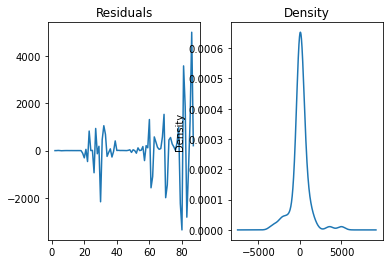

In [ ]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals',ax=ax[0])
residuals.plot(title='Density',kind='kde',ax=ax[1])
plt.show()

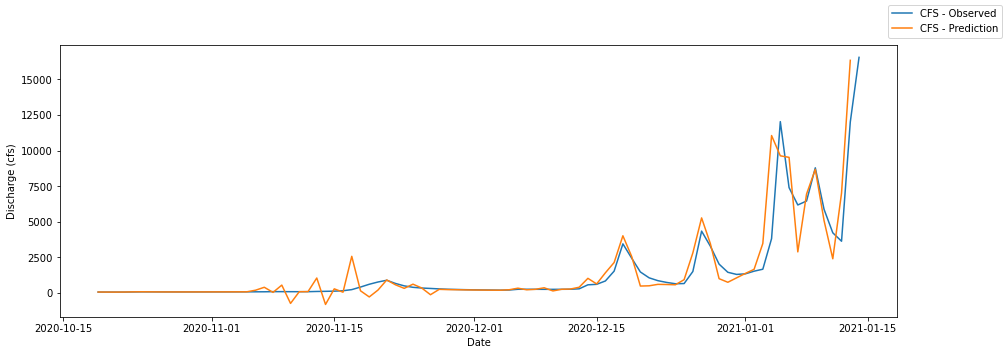

In [137]:
predict = model_fit.predict()

# # Create figure with secondary y-axis
# fig = make_subplots(specs=[[{"secondary_y": False}]])
# # Add traces
# fig.add_trace(
#     go.Scatter(x=eel_train.Date, y=eel_train.CFS, name="CFS - Observed"),
#     secondary_y=False)
# fig.add_trace(
#     go.Scatter(x=eel.Date, y=predict, name="CFS - Predicted"),
#     secondary_y=False)
# # Add figure title
# fig.update_layout(
#     title_text="Observed vs Predicted")
# # Set x-axis title
# fig.update_xaxes(title_text="Date")
# # Set y-axes titles
# fig.update_yaxes(title_text="Discharge (cfs)", secondary_y=False)
# fig.show()


fig, ax = plt.subplots(figsize=(15,5))
ax.plot(eel_train.Date,eel_train.CFS,label='CFS - Observed')
ax.plot(eel_train.Date[:-1],predict,label='CFS - Prediction')

ax.set_xlabel('Date')
ax.set_ylabel('Discharge (cfs)')
fig.legend()

c:\Users\Scott\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



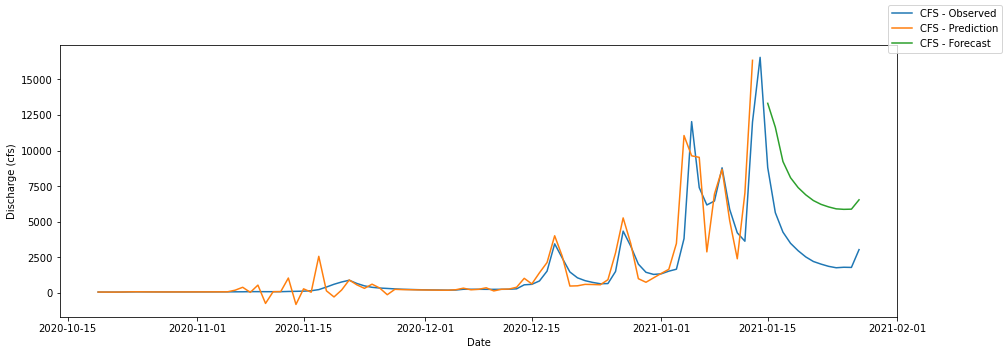

In [139]:
eel_test['CFS_Rolling'] = eel_test.CFS.rolling(window=2,min_periods=1).mean()
eel_test['CFS_Slope_Rolling'] = eel_test.CFS.rolling(window=3,min_periods=1).mean()

forecast = model_fit.forecast(13,exog=eel_test[['CFS_Rolling','Precip_Shift']].dropna())

# # Create figure with secondary y-axis
# fig = make_subplots(specs=[[{"secondary_y": False}]])
# # Add traces
# fig.add_trace(
#     go.Scatter(x=eel.Date, y=eel.CFS, name="CFS - Observed"),
#     secondary_y=False)
# fig.add_trace(
#     go.Scatter(x=eel_train.Date, y=predict, name="CFS - Predicted"),
#     secondary_y=False)
# fig.add_trace(
#     go.Scatter(x=eel_test.Date, y=forecast, name="CFS - Forecast"),
#     secondary_y=False)
# # Add figure title
# fig.update_layout(
#     title_text="Observed, Predicted, & Forecasted ")
# # Set x-axis title
# fig.update_xaxes(title_text="Date")
# # Set y-axes titles
# fig.update_yaxes(title_text="Discharge (cfs)", secondary_y=False)
# fig.show()



fig, ax = plt.subplots(figsize=(15,5))
ax.plot(eel.Date,eel.CFS,label='CFS - Observed')
ax.plot(eel_train.Date[:-1],predict,label='CFS - Prediction')
ax.plot(eel_test.Date,forecast,label='CFS - Forecast')

ax.set_xlabel('Date')
ax.set_ylabel('Discharge (cfs)')
fig.legend()